In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim
from sklearn.metrics import root_mean_squared_error

# Explaratory Data Analysis

In [2]:
import pandas as pd

TRAIN_PATH = 'data/train.csv'
TRAIN_EXTRA = 'data/training_extra.csv'

# Load both CSV files
df1 = pd.read_csv(TRAIN_PATH, index_col='id')
df2 = pd.read_csv(TRAIN_EXTRA, index_col='id')

# Concatenate them along rows (axis=0)
#df = pd.concat([df1, df2])
df = df1

# Reset index if needed (optional)
#df = df.reset_index()

print(f"Combined Data Shape: {df.shape}")
df.head()

Combined Data Shape: (300000, 10)


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 25.2+ MB


In [4]:
df.nunique()

Brand                        5
Material                     4
Size                         3
Compartments                10
Laptop Compartment           2
Waterproof                   2
Style                        3
Color                        6
Weight Capacity (kg)    181596
Price                    48212
dtype: int64

In [5]:
df.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [6]:
print('Count of Missing Values per Column:')
df.isna().sum()

Count of Missing Values per Column:


Brand                   9705
Material                8347
Size                    6595
Compartments               0
Laptop Compartment      7444
Waterproof              7050
Style                   7970
Color                   9950
Weight Capacity (kg)     138
Price                      0
dtype: int64

/Users/arjein/Documents/GitHub/kaggle/backpack/.venv/lib/python3.12/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


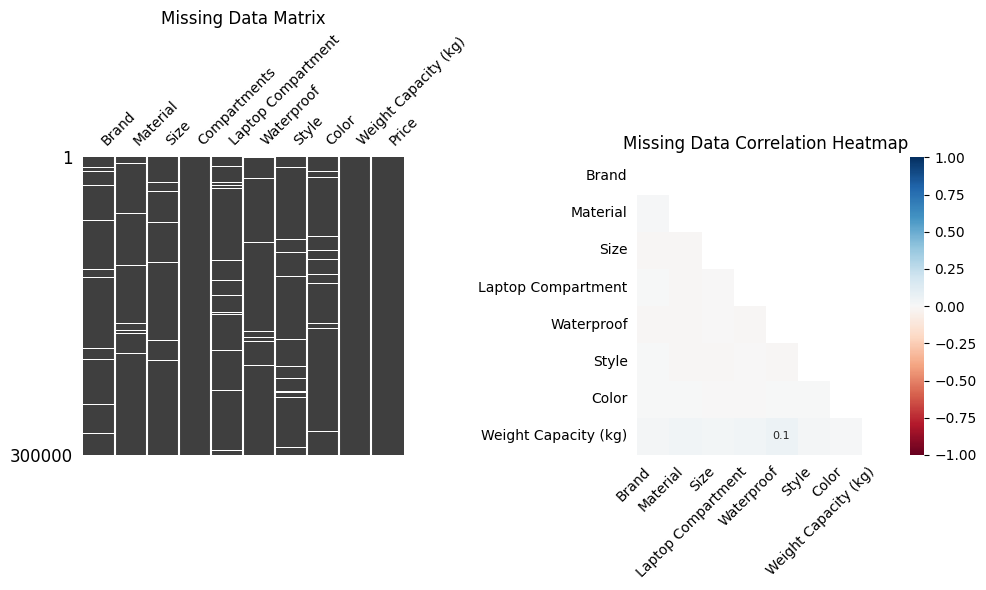

In [7]:
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Missing data matrix (left side)
msno.matrix(df, ax=axes[0], fontsize=10)
axes[0].set_title("Missing Data Matrix")

# Missing data heatmap (right side)
msno.heatmap(df, ax=axes[1], fontsize=10)
axes[1].set_title("Missing Data Correlation Heatmap")

plt.tight_layout()
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import TargetEncoder
import pandas as pd
#Encode Labels    
from sklearn.preprocessing import OneHotEncoder
# Step 1: Impute missing values with the most frequent category (mode)
scaler = StandardScaler()

cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')
ohe = OneHotEncoder(drop='first', sparse_output=False)

In [9]:
def preprocess_dataframe(dataframe: pd.DataFrame, isTest=False, scaler=None, cat_imputer=None, num_imputer=None, ohe=None):
    df = dataframe.copy()

    categorical_features = ['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color']
    numeric_features = ['Compartments', 'Weight Capacity (kg)']
    
    # Ensure preprocessors exist
    if scaler is None or cat_imputer is None or num_imputer is None or ohe is None:
        raise ValueError("Preprocessors (scaler, cat_imputer, num_imputer, ohe) must be provided!")

    # Impute Missing Values    
    if not isTest:
        df[categorical_features] = cat_imputer.fit_transform(df[categorical_features])
        df[numeric_features] = num_imputer.fit_transform(df[numeric_features])
    else:
        df[categorical_features] = cat_imputer.transform(df[categorical_features])
        df[numeric_features] = num_imputer.transform(df[numeric_features])

    # Feature Engineering (before scaling!)
    df['Capacity/Compartment'] = df['Weight Capacity (kg)'] / df['Compartments']
    num_features = numeric_features.copy()
    num_features.append('Capacity/Compartment')

    # Scale Numeric Features
    if not isTest:
        df[num_features] = scaler.fit_transform(df[num_features])
    else:
        df[num_features] = scaler.transform(df[num_features])

    print(df.isna().sum())

    # Encode Categorical Features
    if not isTest:
        encoded = ohe.fit_transform(df[categorical_features])
    else:
        encoded = ohe.transform(df[categorical_features])
    
    encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(categorical_features), index=df.index)

    print(encoded_df.isna().sum())

    # Drop original categorical columns and join encoded data
    df = df.drop(columns=categorical_features).join(encoded_df)

    print(df.isna().sum())
    return df

In [10]:
df = preprocess_dataframe(dataframe=df, scaler=scaler, cat_imputer=cat_imputer, num_imputer=num_imputer, ohe=ohe)
df.head()

Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Price                   0
Capacity/Compartment    0
dtype: int64
Brand_Jansport            0
Brand_Nike                0
Brand_Puma                0
Brand_Under Armour        0
Material_Leather          0
Material_Nylon            0
Material_Polyester        0
Size_Medium               0
Size_Small                0
Laptop Compartment_Yes    0
Waterproof_Yes            0
Style_Messenger           0
Style_Tote                0
Color_Blue                0
Color_Gray                0
Color_Green               0
Color_Pink                0
Color_Red                 0
dtype: int64
Compartments              0
Weight Capacity (kg)      0
Price                     0
Capacity/Compartment      0
Brand_Jansport            0
Brand_Nike                0
Brand_Puma      

,Compartments,Weight Capacity (kg),Price,Capacity/Compartment,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
id,,,,,,,,,,,,,,,,,,,,,
0,0.538408,-0.921466,112.15875,-0.667286,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.576198,1.299086,68.88056,-0.479310,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-1.191240,-0.199023,39.17320,0.526663,0.0,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.884338,-0.731166,80.60793,-0.674752,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-1.537170,-0.040296,86.02312,2.215964,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
TEST_PATH = 'data/test.csv'
df_test = pd.read_csv(TEST_PATH, index_col='id')
df_test = preprocess_dataframe(df_test, isTest=True, scaler=scaler, cat_imputer=cat_imputer, num_imputer=num_imputer, ohe=ohe)
df_test

Brand                   0
Material                0
Size                    0
Compartments            0
Laptop Compartment      0
Waterproof              0
Style                   0
Color                   0
Weight Capacity (kg)    0
Capacity/Compartment    0
dtype: int64
Brand_Jansport            0
Brand_Nike                0
Brand_Puma                0
Brand_Under Armour        0
Material_Leather          0
Material_Nylon            0
Material_Polyester        0
Size_Medium               0
Size_Small                0
Laptop Compartment_Yes    0
Waterproof_Yes            0
Style_Messenger           0
Style_Tote                0
Color_Blue                0
Color_Gray                0
Color_Green               0
Color_Pink                0
Color_Red                 0
dtype: int64
Compartments              0
Weight Capacity (kg)      0
Capacity/Compartment      0
Brand_Jansport            0
Brand_Nike                0
Brand_Puma                0
Brand_Under Armour        0
Material_Leath

,Compartments,Weight Capacity (kg),Capacity/Compartment,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,Material_Polyester,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
id,,,,,,,,,,,,,,,,,,,,,
300000,-1.191240,0.379185,0.887496,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
300001,0.538408,-0.641165,-0.617308,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
300002,1.230268,-0.893029,-0.729397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
300003,-1.537170,0.064179,2.346359,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
300004,-1.191240,-1.166074,-0.076829,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,-1.191240,-1.528508,-0.303007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
499996,1.230268,-1.718751,-0.843907,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
499997,1.230268,1.272042,-0.429148,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [12]:
for col in df.columns:
    unique_vals = df[col].nunique()
    print(f"{col}: {unique_vals} unique values")
for col in df.columns:
    mean_price = df.groupby(col)['Price'].mean().sort_values()
    print(f"\nMean Price for {col}:\n{mean_price}")

Compartments: 10 unique values
Weight Capacity (kg): 181590 unique values
Price: 48212 unique values
Capacity/Compartment: 253396 unique values
Brand_Jansport: 2 unique values
Brand_Nike: 2 unique values
Brand_Puma: 2 unique values
Brand_Under Armour: 2 unique values
Material_Leather: 2 unique values
Material_Nylon: 2 unique values
Material_Polyester: 2 unique values
Size_Medium: 2 unique values
Size_Small: 2 unique values
Laptop Compartment_Yes: 2 unique values
Waterproof_Yes: 2 unique values
Style_Messenger: 2 unique values
Style_Tote: 2 unique values
Color_Blue: 2 unique values
Color_Gray: 2 unique values
Color_Green: 2 unique values
Color_Pink: 2 unique values
Color_Red: 2 unique values

Mean Price for Compartments:
Compartments
 1.230268    80.418818
-1.191240    81.171776
-1.537170    81.263845
-0.845310    81.332909
 0.538408    81.440569
 0.192479    81.452368
-0.153451    81.477310
 1.576198    81.685283
 0.884338    81.906747
-0.499381    81.969078
Name: Price, dtype: float64

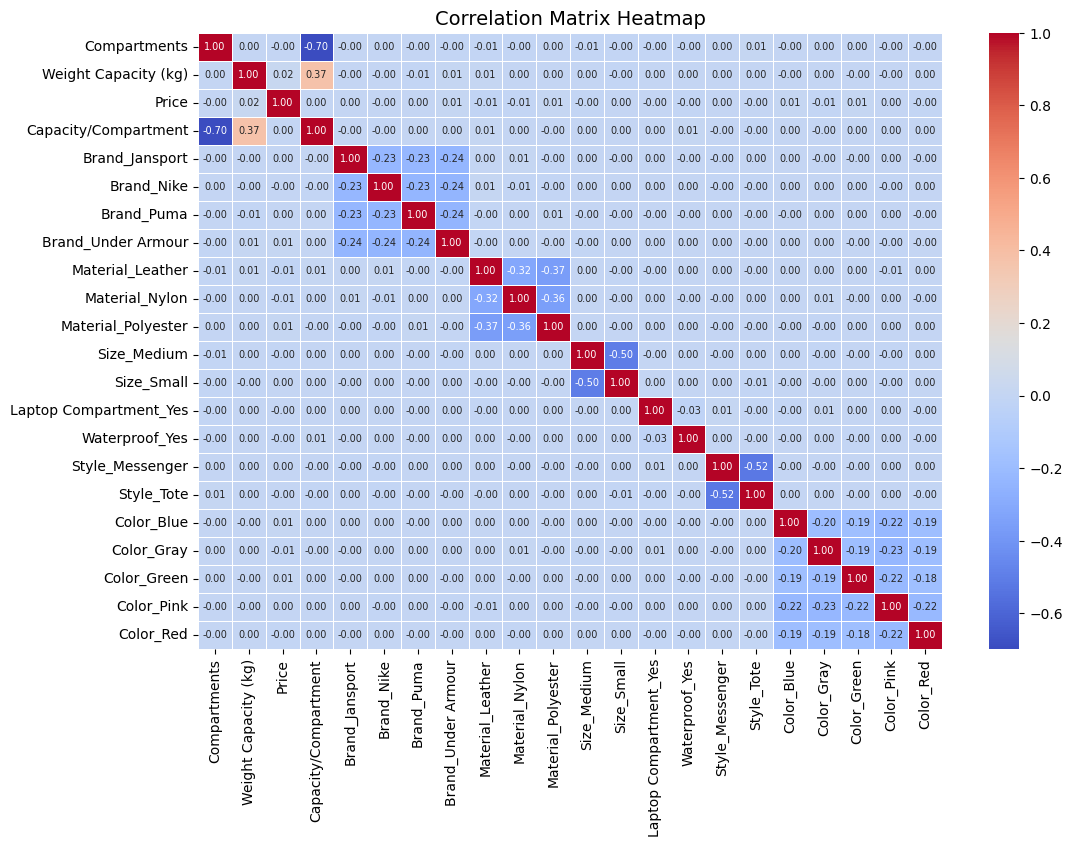

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(12, 8))

# Create heatmap with smaller font size
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap="coolwarm", 
            linewidths=0.5, 
            annot_kws={"size": 7})  # Adjust font size

# Set title
plt.title("Correlation Matrix Heatmap", fontsize=14)

# Show plot
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import pandas as pd

# Split the data into training and testing sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
device ='mps'


In [15]:
df_train.head()

,Compartments,Weight Capacity (kg),Price,Capacity/Compartment,Brand_Jansport,Brand_Nike,Brand_Puma,Brand_Under Armour,Material_Leather,Material_Nylon,...,Size_Small,Laptop Compartment_Yes,Waterproof_Yes,Style_Messenger,Style_Tote,Color_Blue,Color_Gray,Color_Green,Color_Pink,Color_Red
id,,,,,,,,,,,,,,,,,,,,,
254099,-1.537170,1.330146,41.12467,3.926423,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
53461,1.230268,-1.357510,114.18732,-0.793810,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
247984,0.884338,-0.937156,18.86501,-0.706890,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
209067,-0.845310,-1.234217,80.62604,-0.401079,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185997,0.884338,-1.300558,144.64547,-0.763585,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
class BackpackDataset(Dataset):
    def __init__(self, df, isTest= False):
        self.isTest = isTest
        if not self.isTest:
            self.X = torch.tensor(df.drop(columns=['Price']).values, dtype=torch.float32)  # Features
            self.y = torch.tensor(df['Price'].values, dtype=torch.float32)  # Target
        else:
            self.X = torch.tensor(df.values, dtype= torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if not self.isTest:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [17]:
train_dataset = BackpackDataset(df=df_train, isTest= False)
val_dataset = BackpackDataset(df=df_val, isTest=False)
BATCH_SIZE= 64

In [18]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
import torch
from torch import nn
torch.manual_seed(1337)

class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super().__init__()
        
        self.layer_1 = nn.Sequential(
        nn.Linear(input_dim, hidden_units),
        nn.BatchNorm1d(hidden_units),  # Normalize features
        nn.LeakyReLU(negative_slope=0.01),
        nn.Dropout(p=0.2)                                   # Dropout with 50% probability

        )
        self.layer_2 = nn.Sequential(
        nn.Linear(hidden_units, hidden_units * 4),
        nn.BatchNorm1d(hidden_units * 4),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Dropout(p=0.2)                                   # Dropout with 50% probability

        )
        self.layer_3 = nn.Sequential(
        nn.Linear(hidden_units * 4, hidden_units),
        nn.BatchNorm1d(hidden_units),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Dropout(p=0.2)                                   # Dropout with 50% probability
        )
        self.layer_4 = nn.Sequential(
        nn.Linear(hidden_units, hidden_units),
        nn.BatchNorm1d(hidden_units),
        nn.LeakyReLU(negative_slope=0.01),
        nn.Dropout(p=0.2)                                   # Dropout with 50% probability
        )
        self.output_layer = nn.Linear(hidden_units, output_dim)

    def forward(self, x):
        x = self.layer_1(x)
        #print(f'After First Layer: {x[:1]}')
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        #print(f'After Second Layer: {x[:1]}')
        x = self.output_layer(x)
        #print(f'After Output Layer: {x[:1]}')
        return x
    
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [20]:
x_b, y_b = next(iter(train_loader))
x_b, y_b = x_b.to(device), y_b.to(device)

In [21]:
model_kwargs = {'input_features': x_b.shape[1],
                'hidden_units': 64,
                'out_features': 1,
                }
model = NeuralNet(model_kwargs['input_features'], model_kwargs['hidden_units'], model_kwargs['out_features']).to(device)
model.apply(init_weights)
model.state_dict


<bound method Module.state_dict of NeuralNet(
  (layer_1): Sequential(
    (0): Linear(in_features=21, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layer_2): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layer_3): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.2, inplace=False)
  )
  (layer_4): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2

In [22]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)



/Users/arjein/Documents/GitHub/kaggle/backpack/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [23]:
print("Mean:", df["Price"].mean(), " | Std:", df["Price"].std())

Mean: 81.41110683033334  | Std: 39.039340377126834


In [24]:

# Forward Pass
with torch.inference_mode():
    pred = model(x_b).squeeze()
    # Loss
    init_loss = loss_fn(pred, y_b)
    print(f'Shape of x_b: {x_b.shape} | Shape of y_b: {y_b.shape} | Shape of pred: {pred.shape}')
    print(f"Prediction : {pred[:5]} | Actual {y_b[:5]} | Initial Loss: {init_loss}")


Shape of x_b: torch.Size([64, 21]) | Shape of y_b: torch.Size([64]) | Shape of pred: torch.Size([64])
Prediction : tensor([-0.4814,  0.4451, -2.7744, -2.6114, -0.8832], device='mps:0') | Actual tensor([120.7141, 115.7464,  36.1717,  61.8152,  68.1299], device='mps:0') | Initial Loss: 8747.86328125


In [25]:
torch.manual_seed(1337)
from tqdm import tqdm
# Training the Network
def train_step(dataloader, model, loss_fn, optimizer, metrics_fn):
    model.train()
    train_loss, train_rmse = 0, 0
    
    for batch, (X_b, y_b) in enumerate(dataloader):
        X_b, y_b = X_b.to(device), y_b.to(device)
        # Forward Pass
        y_pred = model(X_b).squeeze()
        # Loss
        loss = loss_fn(y_pred, y_b)
        e = metrics_fn(y_pred.to('cpu').detach(), y_b.to('cpu'))
        train_loss += loss.item()
        train_rmse += e
        # Zero grad
        optimizer.zero_grad()
        # Backprop
        loss.backward()
        # Optimizer Step
        optimizer.step()
        
        #print(f'Train Loss ({batch}): {loss}')

    train_loss /= len(dataloader)
    train_rmse /= len(dataloader)

    return train_loss, train_rmse

def val_step(dataloader, model, loss_fn, metrics_fn):
    model.eval()
    val_loss = 0
    val_rmse = 0
    with torch.inference_mode():
        for batch, (X_b, y_b) in enumerate(dataloader):
            X_b, y_b = X_b.to(device), y_b.to(device)
            y_pred = model(X_b).squeeze()
            val_loss += loss_fn(y_pred, y_b).item()
            val_rmse += metrics_fn(y_pred.to('cpu').detach(), y_b.to('cpu'))
        
        val_loss /= len(dataloader)
        val_rmse /= len(dataloader)

    return val_loss, val_rmse


def train_model(epochs):
    for epoch in tqdm(range(1, epochs + 1)):
        print(f'Epoch {epoch}: ----- |  Learning Rate: {scheduler.optimizer.param_groups[0]['lr']}\n')
        train_loss, train_rmse = train_step(dataloader=train_loader, model=model, loss_fn=loss_fn, optimizer=optimizer, metrics_fn=root_mean_squared_error)
        val_loss, val_rmse = val_step(dataloader=val_loader, model=model, loss_fn=loss_fn,  metrics_fn=root_mean_squared_error)
        print(f'Train Loss: {train_loss} | Validation Loss: {val_loss}')
        print(f'Train RMSE: {train_rmse} | Validation RMSE: {val_rmse}')
            # Step the scheduler based on validation loss at the end of each epoch
        
        scheduler.step(val_loss)
        print('Saving Model')
        torch.save(model.state_dict(), f"models/model_checkpoint_{epoch}.pth")


    

In [26]:
torch.manual_seed(1337)
epochs = 25
train_model(epochs)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1: ----- |  Learning Rate: 0.001



  4%|▍         | 1/25 [00:22<09:11, 22.98s/it]

Train Loss: 2356.424075716146 | Validation Loss: 1525.7310537244718
Train RMSE: 46.36465423754511 | Validation RMSE: 38.99570501351526
Saving Model
Epoch 2: ----- |  Learning Rate: 0.001



  8%|▊         | 2/25 [00:46<08:55, 23.29s/it]

Train Loss: 1581.020699934896 | Validation Loss: 1525.79994523754
Train RMSE: 39.6919562327896 | Validation RMSE: 38.99716702353188
Saving Model
Epoch 3: ----- |  Learning Rate: 0.001



 12%|█▏        | 3/25 [01:09<08:30, 23.19s/it]

Train Loss: 1574.3662985839844 | Validation Loss: 1526.033201172916
Train RMSE: 39.60820730764783 | Validation RMSE: 39.000471902829965
Saving Model
Epoch 4: ----- |  Learning Rate: 0.001



 16%|█▌        | 4/25 [01:32<08:06, 23.16s/it]

Train Loss: 1570.1561584309895 | Validation Loss: 1517.9963529867405
Train RMSE: 39.559181149788195 | Validation RMSE: 38.89839702338675
Saving Model
Epoch 5: ----- |  Learning Rate: 0.001



 20%|██        | 5/25 [01:55<07:43, 23.16s/it]

Train Loss: 1567.964696028646 | Validation Loss: 1519.6860472591702
Train RMSE: 39.526272852642336 | Validation RMSE: 38.920014547945094
Saving Model
Epoch 6: ----- |  Learning Rate: 0.001



 24%|██▍       | 6/25 [02:18<07:19, 23.14s/it]

Train Loss: 1563.8658944498698 | Validation Loss: 1516.2498504703742
Train RMSE: 39.47745531489631 | Validation RMSE: 38.87672758567704
Saving Model
Epoch 7: ----- |  Learning Rate: 0.001



 28%|██▊       | 7/25 [02:43<07:04, 23.57s/it]

Train Loss: 1561.5732189127605 | Validation Loss: 1516.8433373294658
Train RMSE: 39.45045914846147 | Validation RMSE: 38.88518386339661
Saving Model
Epoch 8: ----- |  Learning Rate: 0.001



 32%|███▏      | 8/25 [03:06<06:39, 23.51s/it]

Train Loss: 1559.8730663085937 | Validation Loss: 1516.0976553390276
Train RMSE: 39.42834923555512 | Validation RMSE: 38.875463190115006
Saving Model
Epoch 9: ----- |  Learning Rate: 0.001



 36%|███▌      | 9/25 [03:29<06:12, 23.27s/it]

Train Loss: 1558.3172660970051 | Validation Loss: 1517.4082338377866
Train RMSE: 39.408244410194385 | Validation RMSE: 38.89149548733096
Saving Model
Epoch 10: ----- |  Learning Rate: 0.001



 40%|████      | 10/25 [03:52<05:46, 23.10s/it]

Train Loss: 1556.4101009602864 | Validation Loss: 1515.5068890341818
Train RMSE: 39.38642341112232 | Validation RMSE: 38.86779935481115
Saving Model
Epoch 11: ----- |  Learning Rate: 0.001



 44%|████▍     | 11/25 [04:14<05:21, 22.98s/it]

Train Loss: 1553.3936595377604 | Validation Loss: 1515.9607545246702
Train RMSE: 39.345434750284376 | Validation RMSE: 38.873728257448576
Saving Model
Epoch 12: ----- |  Learning Rate: 0.001



 48%|████▊     | 12/25 [04:37<04:57, 22.87s/it]

Train Loss: 1554.203291048177 | Validation Loss: 1515.600376674107
Train RMSE: 39.356744908617635 | Validation RMSE: 38.86849886048551
Saving Model
Epoch 13: ----- |  Learning Rate: 0.001



 52%|█████▏    | 13/25 [05:00<04:33, 22.81s/it]

Train Loss: 1551.6206748372397 | Validation Loss: 1515.313283176056
Train RMSE: 39.323899358538625 | Validation RMSE: 38.86491649595431
Saving Model
Epoch 14: ----- |  Learning Rate: 0.001



 56%|█████▌    | 14/25 [05:24<04:16, 23.32s/it]

Train Loss: 1552.0242134928385 | Validation Loss: 1516.493134390825
Train RMSE: 39.32763481686958 | Validation RMSE: 38.87979115728112
Saving Model
Epoch 15: ----- |  Learning Rate: 0.001



 60%|██████    | 15/25 [05:47<03:52, 23.29s/it]

Train Loss: 1551.4885336914062 | Validation Loss: 1515.0619623310276
Train RMSE: 39.32254091590165 | Validation RMSE: 38.861986719405905
Saving Model
Epoch 16: ----- |  Learning Rate: 0.001



 64%|██████▍   | 16/25 [06:10<03:28, 23.11s/it]

Train Loss: 1552.022512109375 | Validation Loss: 1516.4176709921376
Train RMSE: 39.32973982706315 | Validation RMSE: 38.878640111316216
Saving Model
Epoch 17: ----- |  Learning Rate: 0.001



 68%|██████▊   | 17/25 [06:35<03:08, 23.56s/it]

Train Loss: 1550.7182956054687 | Validation Loss: 1515.4994096898322
Train RMSE: 39.31842658990361 | Validation RMSE: 38.86748522068823
Saving Model
Epoch 18: ----- |  Learning Rate: 0.001



 72%|███████▏  | 18/25 [06:58<02:43, 23.42s/it]

Train Loss: 1548.6999503255208 | Validation Loss: 1515.8816011668778
Train RMSE: 39.28895195670114 | Validation RMSE: 38.872349765304946
Saving Model
Epoch 19: ----- |  Learning Rate: 0.001



 76%|███████▌  | 19/25 [07:21<02:19, 23.23s/it]

Train Loss: 1548.037054296875 | Validation Loss: 1516.3523209496602
Train RMSE: 39.28051205242192 | Validation RMSE: 38.87812885085603
Saving Model
Epoch 20: ----- |  Learning Rate: 0.001



 80%|████████  | 20/25 [07:44<01:55, 23.14s/it]

Train Loss: 1549.1772188802083 | Validation Loss: 1515.6534719243487
Train RMSE: 39.29237411019818 | Validation RMSE: 38.86976520060958
Saving Model
Epoch 21: ----- |  Learning Rate: 0.001



 84%|████████▍ | 21/25 [08:06<01:32, 23.04s/it]

Train Loss: 1547.9162053548177 | Validation Loss: 1516.3766974020107
Train RMSE: 39.277451164135044 | Validation RMSE: 38.879044693146525
Saving Model
Epoch 22: ----- |  Learning Rate: 0.0001



 88%|████████▊ | 22/25 [08:29<01:08, 22.95s/it]

Train Loss: 1546.8595993001302 | Validation Loss: 1516.0456535160415
Train RMSE: 39.26384567874748 | Validation RMSE: 38.874314885436974
Saving Model
Epoch 23: ----- |  Learning Rate: 0.0001



 92%|█████████▏| 23/25 [08:54<00:47, 23.60s/it]

Train Loss: 1547.731634798177 | Validation Loss: 1516.1294264152868
Train RMSE: 39.27691736685287 | Validation RMSE: 38.875222780292795
Saving Model
Epoch 24: ----- |  Learning Rate: 0.0001



 96%|█████████▌| 24/25 [09:17<00:23, 23.41s/it]

Train Loss: 1545.6635494140626 | Validation Loss: 1515.9001349020107
Train RMSE: 39.248921843251686 | Validation RMSE: 38.87248340283235
Saving Model
Epoch 25: ----- |  Learning Rate: 0.0001



100%|██████████| 25/25 [09:40<00:00, 23.22s/it]

Train Loss: 1545.519925390625 | Validation Loss: 1515.9049893442248
Train RMSE: 39.244986121844235 | Validation RMSE: 38.872534623572434
Saving Model


In [34]:
torch.manual_seed(1337)
model_state_dict = torch.load('models/model_checkpoint_15.pth', weights_only=True)
model = NeuralNet(model_kwargs['input_features'], model_kwargs['hidden_units'], model_kwargs['out_features']).to(device)
model.load_state_dict(model_state_dict)
model.eval()
for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    y_pred = model(X_batch)
    print("Predictions:", (y_pred.to('cpu').detach())[:5])
    print(y_batch.shape)
    print("Actual:", (y_batch.to('cpu').reshape(-1,1)))
    break

Predictions: tensor([[81.6817],
        [80.5685],
        [82.2170],
        [80.5162],
        [82.1397]])
torch.Size([64])
Actual: tensor([[ 17.3151],
        [134.0245],
        [ 55.7113],
        [ 32.5467],
        [ 65.3852],
        [ 28.3675],
        [138.6160],
        [ 76.6054],
        [ 58.0224],
        [106.5735],
        [ 55.6727],
        [ 31.2950],
        [135.9082],
        [ 83.0494],
        [127.0740],
        [100.2134],
        [ 48.0324],
        [116.2838],
        [ 60.8477],
        [124.7678],
        [ 58.9572],
        [ 43.5816],
        [126.1131],
        [ 34.7012],
        [114.6449],
        [ 95.2456],
        [ 45.4255],
        [ 69.4970],
        [ 64.7749],
        [ 74.2073],
        [ 29.6859],
        [145.1578],
        [ 92.1376],
        [ 93.1655],
        [ 29.5860],
        [138.6772],
        [116.8371],
        [133.8471],
        [150.0000],
        [ 33.6724],
        [ 42.1612],
        [ 74.7643],
        [ 86.4573],
      

In [35]:
torch.manual_seed(1337)
def make_predictions(dataframe):
    model.eval()
    test_dataset = BackpackDataset(dataframe, isTest=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    preds = []

    with torch.inference_mode():
        for batch, (X) in enumerate(test_loader):
            X = X.to(device)
            pred = model(X).squeeze()
            preds.append(pred.to('cpu').numpy())
    
    preds = np.concatenate(preds, axis=0)
    return preds

preds = make_predictions(df_test)

preds_df = pd.DataFrame(preds, columns=["Price"], index=df_test.index)



In [36]:
preds_df.to_csv('results.csv')
